In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import expipe
import os
import pathlib
import scipy
import scipy.signal as ss
import numpy as np
import exdir
import pandas as pd
import optogenetics as og
import quantities as pq
import shutil
from distutils.dir_util import copy_tree
import elephant as el
import neo
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from matplotlib import mlab
from spike_statistics.core import theta_mod_idx, correlogram

from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


In [3]:
# data_loader = dp.Data()
# actions = data_loader.actions
# project = data_loader.project

max_speed = .5 # m/s only used for speed score
min_speed = 0.02 # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size = 0.02
smoothing_low = 0.03
smoothing_high = 0.06

speed_binsize = 0.02

stim_mask = True
# baseline_duration = 600
baseline_duration = None

data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size, 
    stim_mask=stim_mask, baseline_duration=baseline_duration
)

In [4]:
actions = data_loader.actions
project = data_loader.project

In [5]:
output = pathlib.Path('output/theta-rhythmicity')
(output / 'data').mkdir(parents=True, exist_ok=True)

In [6]:
identify_neurons = actions['identify-neurons']
# sessions = pd.read_csv(identify_neurons.data_path('sessions'))
units = pd.read_csv(identify_neurons.data_path('units'))

In [7]:
def get_lim(action_id):
    stim_times = data_loader.stim_times(action_id)
    if stim_times is None:
        return [0, np.inf]
    stim_times = np.array(stim_times)
    return [stim_times.min(), stim_times.max()]


def compute_stim_freq(action_id):
    stim_times = data_loader.stim_times(action_id)
    if stim_times is None:
        return np.nan
    stim_times = np.array(stim_times)
    return 1 / np.mean(np.diff(stim_times))

In [8]:
def plot_acorr(sptr, binsize=0.01, time_limit=1):
    count, bins = correlogram(
        t1=sptr, t2=None, binsize=binsize, limit=time_limit,  auto=True)
    plt.bar(bins, count, width=binsize)
    plt.axvspan(.05, .07, color='r', alpha=.5)
    plt.axvspan(.1, .14, color='k', alpha=.5)

In [9]:
def zscore(a):
    return (a - a.mean(0)) / a.std(0)


def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m / sd)


def compute_energy(p, f, f1, f2):
    if np.isnan(f1) or np.all(np.isnan(p)):
        return np.nan
    mask = (f > f1) & (f < f2)
    df = f[1] - f[0]
    return np.sum(p[mask]) * df


def compute_band_power(p, f, f1, f2):
    if np.isnan(f1) or np.all(np.isnan(p)):
        return [np.nan] * 2
    from scipy.integrate import simps
    dx = f[1] - f[0]
    mask = (f > f1) & (f < f2)
    # Compute the absolute power by approximating the area under the curve
    band_power = simps(p[mask], dx=dx)
    total_power = simps(p, dx=dx)
    rel_power = band_power / total_power
    return band_power, rel_power


def find_theta_peak(p, f, f1, f2):
    if np.all(np.isnan(p)):
        return np.nan, np.nan
    mask = (f > f1) & (f < f2)
    p_m = p[mask]
    f_m = f[mask]
    peaks, _ = find_peaks(p_m)
    if len(peaks) == 0:
        return np.nan, np.nan
    idx = np.argmax(p_m[peaks])
    return f_m[peaks[idx]], p_m[peaks[idx]]

In [10]:
def compute_half_width(power, freq, max_power, max_frequency, band, band_width=1):
    if np.isnan(max_power):
        return [np.nan] * 3
    
    # estimate baseline power
    low_baseline_mask = (freq > band[0] - band_width) & (freq < band[0])
    high_baseline_mask = (freq > band[1]) & (freq < band[1] + band_width)
    baseline = np.mean(np.concatenate([power[low_baseline_mask], power[high_baseline_mask]]))
    p = power - baseline
    m_p = max_power - baseline
    m_f = max_frequency
    f = freq
    
    # estimate half width
    m_p_half = m_p / 2
    half_p = p - m_p_half
    idx_f = np.where(f <= m_f)[0].max()
    idxs_p1, = np.where(np.diff(half_p[:idx_f + 1] > 0) == 1)
    if len(idxs_p1) == 0:
        return [np.nan] * 3
    m1 = idxs_p1.max()
    idxs_p2, = np.where(np.diff(half_p[idx_f:] > 0) == 1)
    if len(idxs_p2) == 0:
        return [np.nan] * 3
    m2 = idxs_p2.min() + idx_f
#     assert p[m1] < m_p_half < p[m1+1], (p[m1], m_p_half, p[m1+1])
#     assert p[m2] > m_p_half > p[m2+1], (p[m2], m_p_half, p[m2+1])
    
    f1 = interp1d([half_p[m1], half_p[m1 + 1]], [f[m1], f[m1 + 1]])(0)
    f2 = interp1d([half_p[m2], half_p[m2 + 1]], [f[m2], f[m2 + 1]])(0)
    return f1, f2, m_p_half + baseline

In [11]:
def compute_relative_peak(power, freq, max_power, band, band_width=1):
    # estimate baseline power
    low_baseline_mask = (freq > band[0] - band_width) & (freq < band[0])
    high_baseline_mask = (freq > band[1]) & (freq < band[1] + band_width)
    baseline = np.mean(np.concatenate([power[low_baseline_mask], power[high_baseline_mask]]))
    return (max_power - baseline) / abs(baseline)

In [12]:
def compute_stim_peak(p, f, s_f):
    if np.isnan(s_f):
        return np.nan
    return interp1d(f, p)(s_f)

In [13]:
sampling_period = 10 * pq.ms
kernel_width = 10 * pq.ms

kernel = el.kernels.GaussianKernel(kernel_width)

# Define window length (6 seconds)
sampling_frequency = 1 / sampling_period.rescale('s').magnitude

window = int(6 * sampling_frequency)

theta_band_f1, theta_band_f2 = 6, 10 

In [14]:
psd_data, freq_data = {}, {}

def process(row):
    action_id = row['action']
    channel_group = row['channel_group']
    unit_name = row['unit_name']
    
    name = f'{action_id}_{channel_group}_{unit_name}'
    
    sptr = data_loader.spike_train(action_id, channel_group, unit_name)
    
    rate = el.statistics.instantaneous_rate(sptr, sampling_period, kernel=kernel)
    
    freq, p_xx = ss.welch(rate.ravel(), fs=sampling_frequency, nperseg=window, nfft=scipy.fftpack.next_fast_len(window))
#     p_xx = 10 * np.log10(p_xx)
    
    theta_f, theta_p_max = find_theta_peak(p_xx, freq, theta_band_f1, theta_band_f2)
    
    theta_bandpower, theta_relpower = compute_band_power(p_xx, freq, theta_band_f1, theta_band_f2)
    
    theta_relpeak = compute_relative_peak(p_xx, freq, theta_p_max, [theta_band_f1, theta_band_f2])
        
    theta_half_f1, theta_half_f2, theta_half_power = compute_half_width(p_xx, freq, theta_p_max, theta_f, [theta_band_f1, theta_band_f2])
    
    theta_half_width = theta_half_f2 - theta_half_f1
    
    psd_data.update({name: p_xx})
    freq_data.update({name: freq})

    
    # stim
    
    stim_freq = compute_stim_freq(action_id)
    
    stim_p_max = compute_stim_peak(p_xx, freq, stim_freq)
    
    stim_half_f1, stim_half_f2, stim_half_power = compute_half_width(p_xx, freq, stim_p_max, stim_freq, [stim_freq - 1, stim_freq + 1])
    
    stim_half_width = stim_half_f2 - stim_half_f1
    
    stim_bandpower, stim_relpower = compute_band_power(p_xx, freq, stim_freq - 1, stim_freq + 1)
    
    stim_relpeak = compute_relative_peak(p_xx, freq, stim_p_max, [stim_freq - 1, stim_freq + 1])
    
    if len(sptr) == 0:
        theta_score = np.nan
    else:
        theta_score = theta_mod_idx(np.array(sptr))
    
    result = pd.Series({
        'theta_score': theta_score,
        'signal_to_noise': signaltonoise(rate.ravel()),
        'theta_freq': theta_f,
        'theta_peak': theta_p_max,
        'theta_bandpower': theta_bandpower,
        'theta_relpower': theta_relpower,
        'theta_relpeak': theta_relpeak,
        'theta_half_f1': theta_half_f1, 
        'theta_half_f2': theta_half_f2,
        'theta_half_width': theta_half_width,
        'stim_freq': stim_freq,
        'stim_p_max': stim_p_max,
        'stim_half_f1': stim_half_f1, 
        'stim_half_f2': stim_half_f2,
        'stim_half_width': stim_half_width,
        'stim_bandpower': stim_bandpower,
        'stim_relpower': stim_relpower,
        'stim_relpeak': stim_relpeak,
    })
        
    return result

In [15]:
results = units.merge(
    units.progress_apply(process, axis=1), 
    left_index=True, right_index=True)

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/elephant/statistics.py:835: UserWarning: Instantaneous firing rate approximation contains negative values, possibly caused due to machine precision errors.
  warnings.warn("Instantaneous firing rate approximation contains "
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py

In [16]:
pd.DataFrame(psd_data).to_feather(output / 'data' / 'spike_psd.feather')
pd.DataFrame(freq_data).to_feather(output / 'data' / 'freqs.feather')

# Save to expipe

In [17]:
action = project.require_action("theta-rhythmicity")

In [18]:
action.data['results'] = 'results.csv'
results.to_csv(action.data_path('results'), index=False)

In [19]:
copy_tree(output, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_bs_theta_relpeak.tex',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_gridcell_theta_freq.csv',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_ns_inhibited_theta_bandpower.tex',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_ns_inhibited_stim_bandpower.csv',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_bs_not_gridcell_theta_peak.csv',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_bs_not_gridcell_stim_strength.tex',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_gridcell_theta_freq.tex',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_bs_theta_freq.csv',
 '/media/storage/expipe/septum-mec/actions/theta-rhythmicity/data/statistics/values_gridcell_st

In [20]:
septum_mec.analysis.registration.store_notebook(action, "10-calculate-theta-rhythmicity.ipynb")

# Explore

In [15]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})


In [16]:
# action_id_0, channel_0, unit_0 = '1833-200619-1', 6, 163
# action_id_1, channel_1, unit_1 = '1833-200619-2', 6, 28
# action_id_0, channel_0, unit_0 = '1834-220319-3', 2, 46
action_id_1, channel_1, unit_1 = '1834-220319-4', 2, 60

action_id_0, channel_0, unit_0 = '1834-150319-3', 3, 61

In [17]:
lim_0 = get_lim(action_id_0)
lim_1 = get_lim(action_id_1)

sptrs_0 = data_loader.spike_trains(action_id_0, channel_0)

sptrs_1 = data_loader.spike_trains(action_id_1, channel_1)

In [18]:
kernel = el.kernels.GaussianKernel(10*pq.ms)


In [19]:
rate_0 = el.statistics.instantaneous_rate(sptrs_0[unit_0], 10*pq.ms, kernel=kernel)

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/elephant/statistics.py:835: UserWarning: Instantaneous firing rate approximation contains negative values, possibly caused due to machine precision errors.
  warnings.warn("Instantaneous firing rate approximation contains "


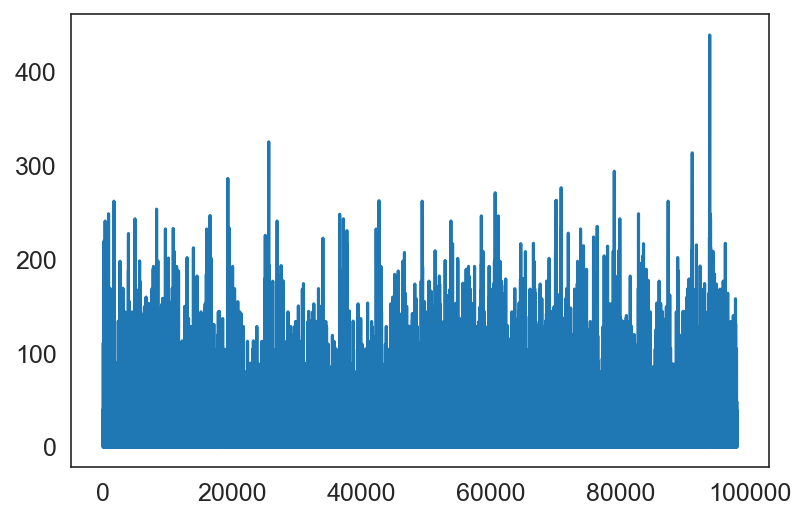

In [20]:
plt.plot(rate_0)
# plt.xlim(0,10000)

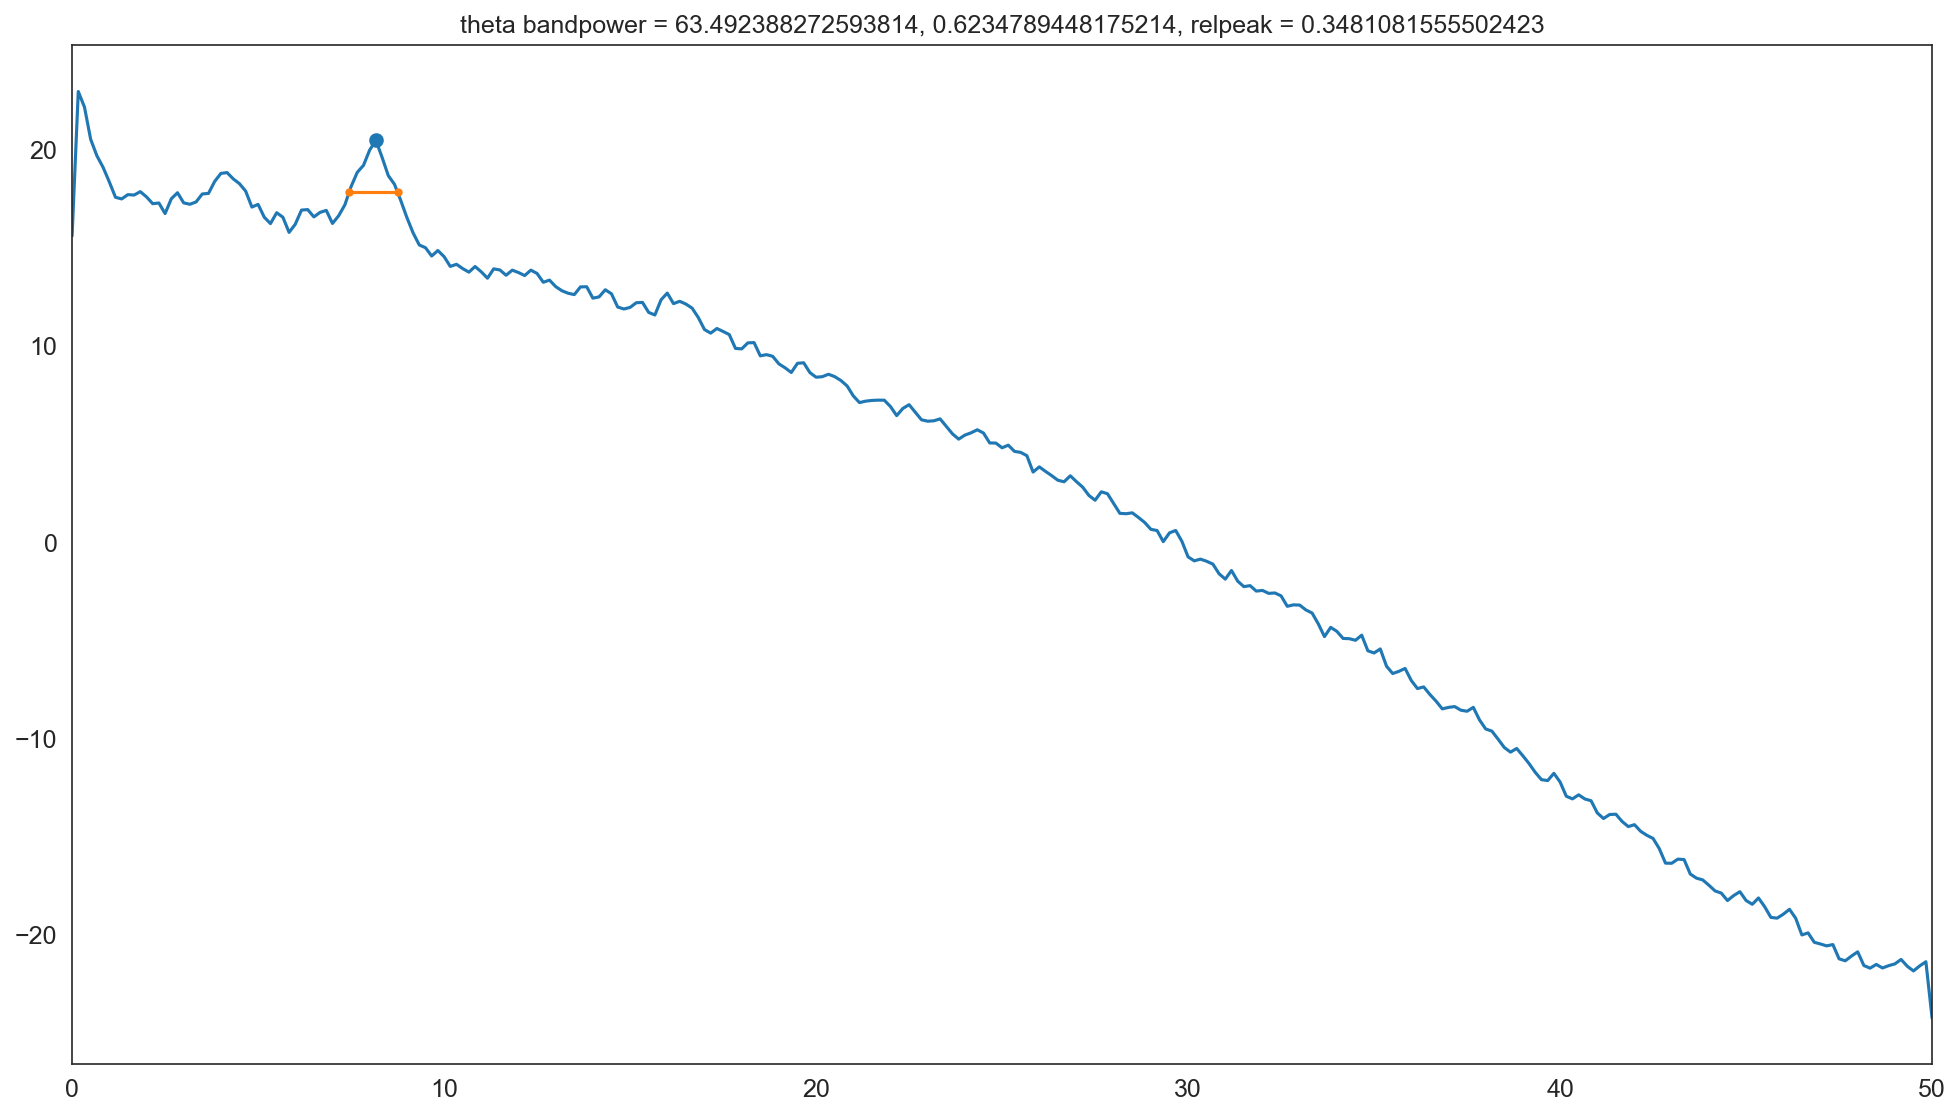

In [22]:
plt.figure(figsize=(16,9))
from scipy import signal

# Define window length (6 seconds)
sf = 100
win = 6 * sf
freq, p_xx = ss.welch(rate_0.ravel(), sf, nperseg=win, nfft=scipy.fftpack.next_fast_len(win))
p_xx = 10*np.log10(p_xx)

theta_f, theta_p_max = find_theta_peak(p_xx, freq, theta_band_f1, theta_band_f2)
    
theta_bandpower, theta_relpower = compute_band_power(p_xx, freq, theta_band_f1, theta_band_f2)

theta_relpeak = compute_relative_peak(p_xx, freq, theta_p_max, [theta_band_f1, theta_band_f2])

theta_half_f1, theta_half_f2, theta_half_power = compute_half_width(p_xx, freq, theta_p_max, theta_f, [theta_band_f1, theta_band_f2])

theta_half_width = theta_half_f2 - theta_half_f1

plt.plot(freq, p_xx)

plt.xlim(0,50)
plt.title(f'theta bandpower = {theta_bandpower}, {theta_relpower}, relpeak = {theta_relpeak}')

plt.scatter(theta_f, theta_p_max)

plt.plot([theta_half_f1, theta_half_f2], [theta_half_power]*2, marker='.')

33.439801780086405 -201.5410642685435
-6.8019949006129155 -201.5410642685435


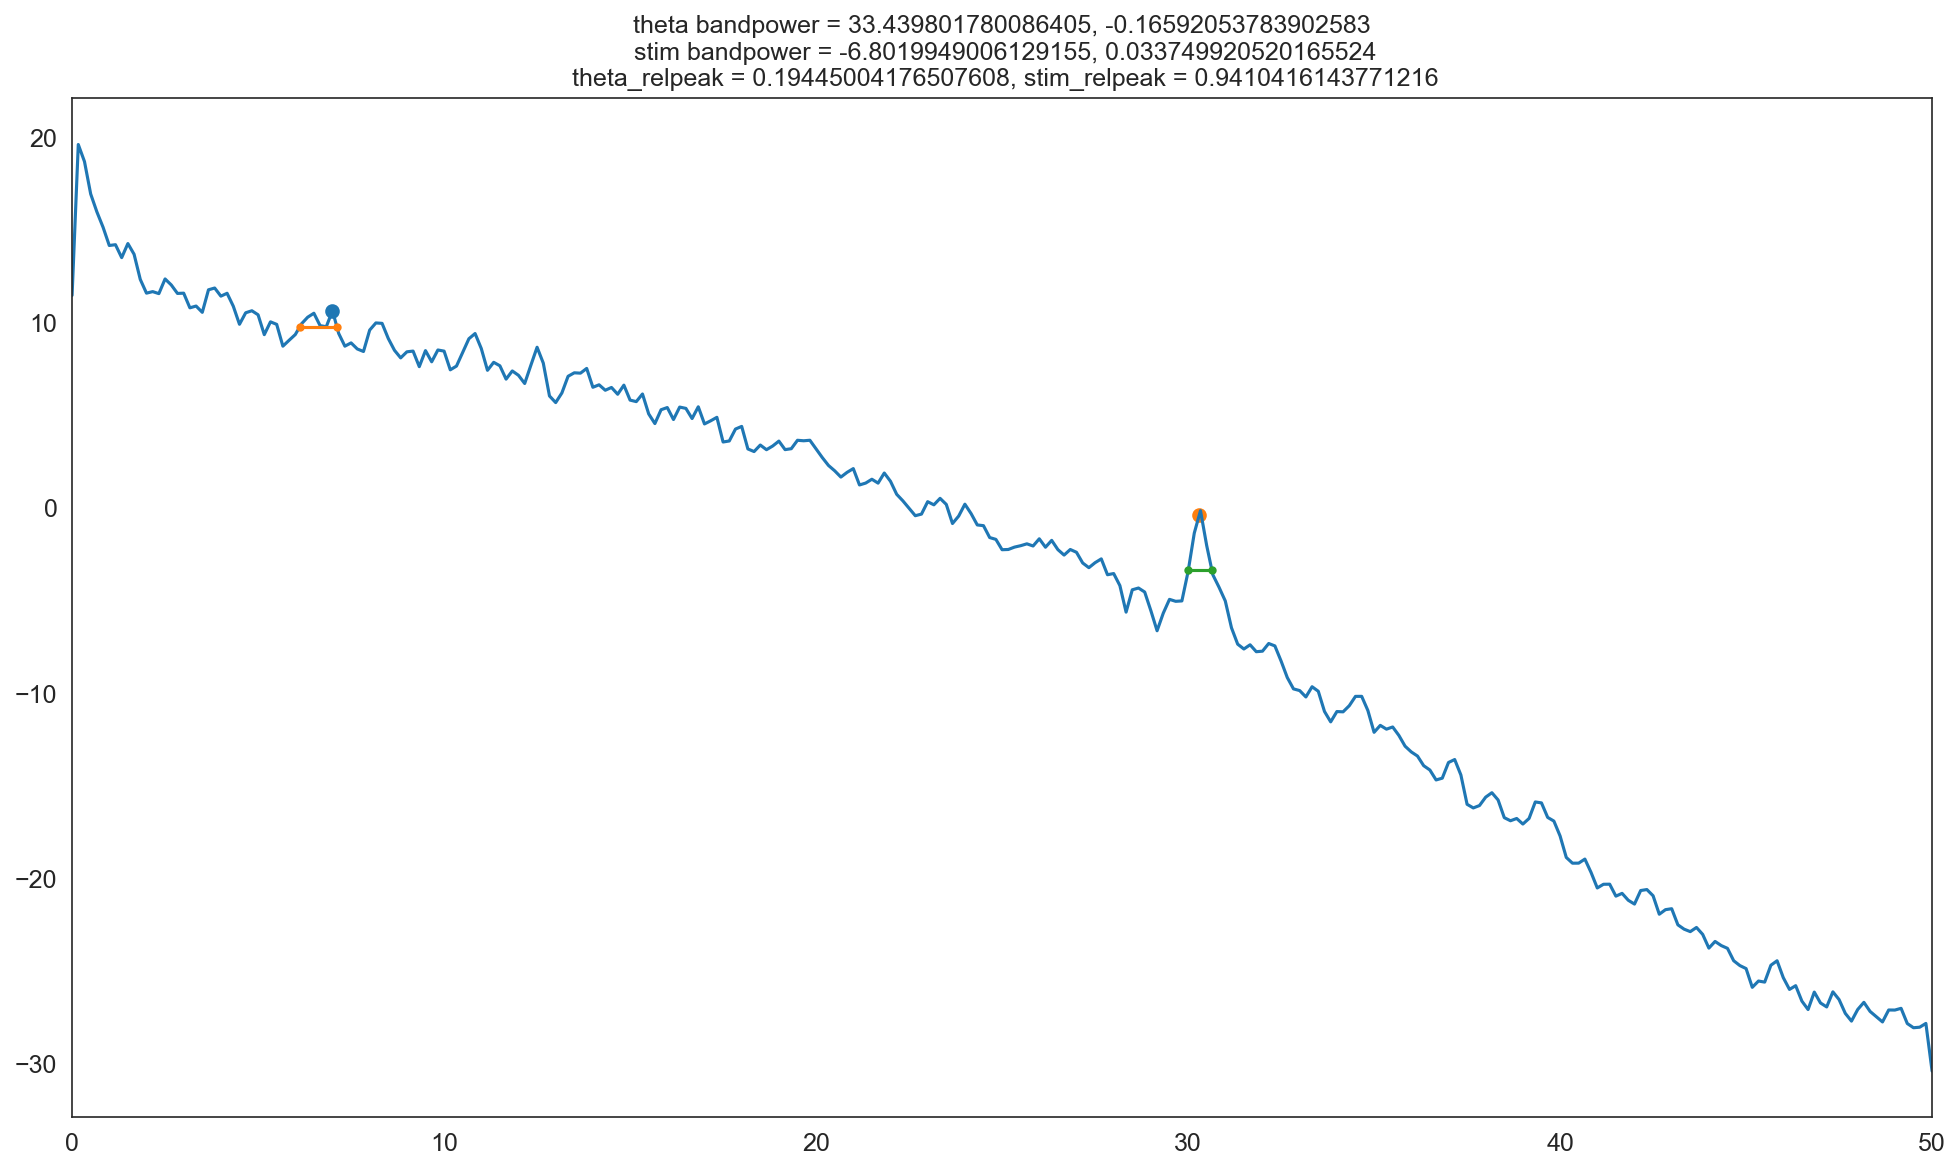

In [77]:
plt.figure(figsize=(16,9))
from scipy import signal
rate_1 = el.statistics.instantaneous_rate(sptrs_1[unit_1], 10*pq.ms, kernel=kernel)

# Define window length (6 seconds)
sf = 100
win = 6 * sf
freq, p_xx = ss.welch(rate_1.ravel(), sf, nperseg=win, nfft=scipy.fftpack.next_fast_len(win))
# freq, p_xx = ss.welch(zscore(rate_1.ravel()), sf, nperseg=win, nfft=scipy.fftpack.next_fast_len(win))
p_xx = 10*np.log10(p_xx)

# p_xx, freq = mlab.psd(zscore(np.array(rate_1).ravel()), Fs=100, NFFT=scipy.fftpack.next_fast_len(1000))

plt.plot(freq, p_xx)
plt.xlim(0,50)
band_power, rel_power = compute_band_power(p_xx, freq, 6, 10)

f, p = find_theta_peak(p_xx, freq, 6, 10)

plt.scatter(f,p)
f1, f2, p_half = compute_half_width(p_xx, freq, p, f, [6,10])

theta_relpeak = compute_relative_peak(p_xx, freq, p, [6,10])

plt.plot([f1, f2], [p_half]*2, marker='.')

stim_freq = compute_stim_freq(action_id_1)

stim_p_max = compute_stim_peak(p_xx, freq, stim_freq)

stim_half_f1, stim_half_f2, stim_half_power = compute_half_width(p_xx, freq, stim_p_max, stim_freq, [stim_freq - 1, stim_freq + 1])

stim_half_width = stim_half_f2 - stim_half_f1

stim_bandpower, stim_relpower = compute_band_power(p_xx, freq, stim_freq - 1, stim_freq + 1)

stim_relpeak = compute_relative_peak(p_xx, freq, stim_p_max, [stim_freq - 1, stim_freq + 1])

plt.title(f'theta bandpower = {band_power}, {rel_power}\n stim bandpower = {stim_bandpower}, {stim_relpower}\n theta_relpeak = {theta_relpeak}, stim_relpeak = {stim_relpeak}')

plt.plot([stim_half_f1, stim_half_f2], [stim_half_power]*2, marker='.')

plt.scatter(stim_freq, stim_p_max)

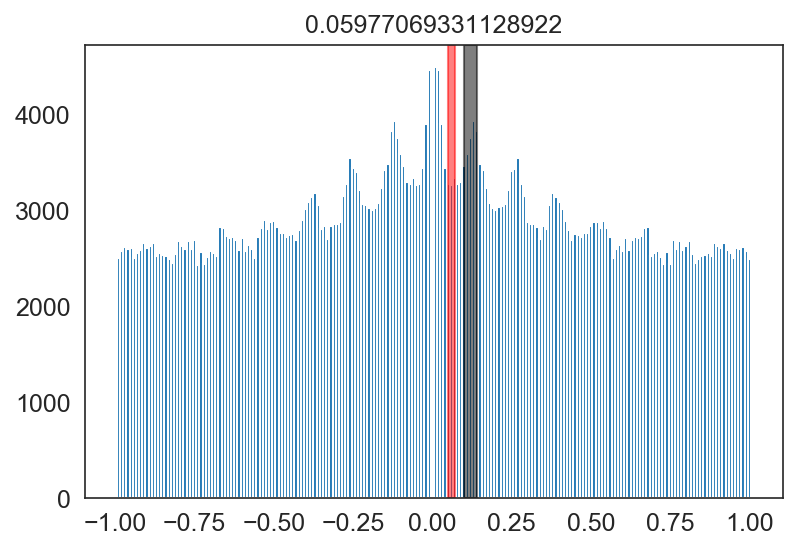

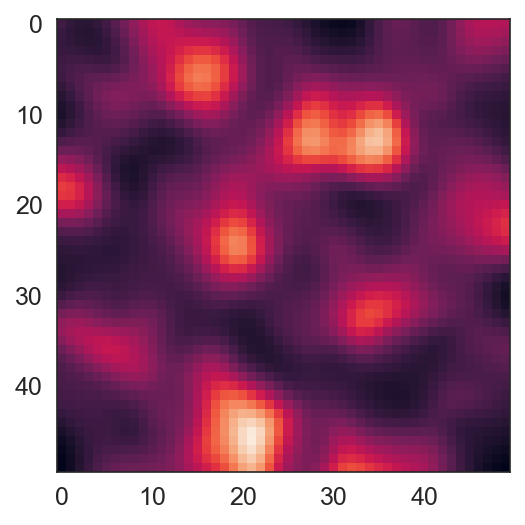

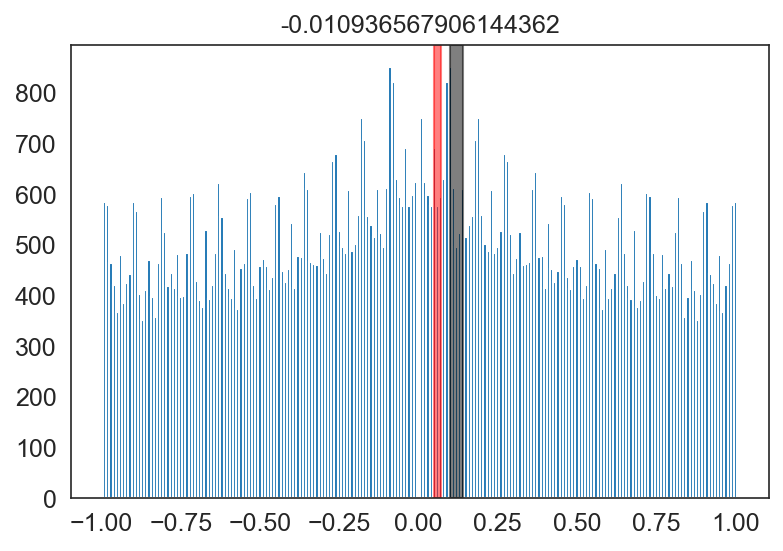

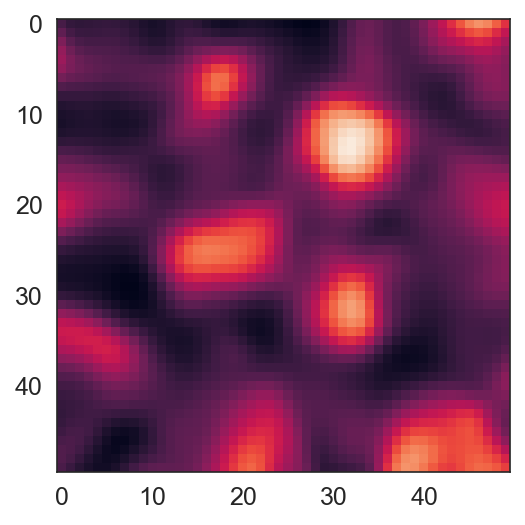

In [45]:


plt.figure()
plot_acorr(np.array(sptrs_0[unit_0]))
plt.title(f'{theta_mod_idx(np.array(sptrs_0[unit_0]))}')

plt.figure()
plt.imshow(data_loader.rate_map(action_id_0, channel_0, unit_0, 0.04))

plt.figure()
plot_acorr(np.array(sptrs_1[unit_1]))
plt.title(f'{theta_mod_idx(np.array(sptrs_1[unit_1]))}')

plt.figure()
plt.imshow(data_loader.rate_map(action_id_1, channel_1, unit_1, 0.04))